In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)


## Maximum Likelihood Estimation

In [185]:
# Sample data: Normally distributed with true parameters mu=0, sigma=1
data = np.random.normal(0, 1, 1000)


In [186]:
# Define the likelihood function
def neg_log_likelihood(params):
    mu, sigma = params[0], params[1]
    # We will minimize the negative log-likelihood
    return -np.sum(np.log(norm.pdf(data, mu, sigma)))


In [187]:
# Initial parameter guesses
initial_params = [np.mean(data), np.std(data)]


In [188]:
# Minimize the negative log-likelihood
result = minimize(neg_log_likelihood, initial_params, method='L-BFGS-B', bounds=[(-10, 10), (0.01, 10)])


In [189]:
# The estimated parameters are
mu_est, sigma_est = result.x
print(f"Estimated mu: {mu_est}, Estimated sigma: {sigma_est}")


Estimated mu: -0.009706700681367047, Estimated sigma: 0.980746388692814


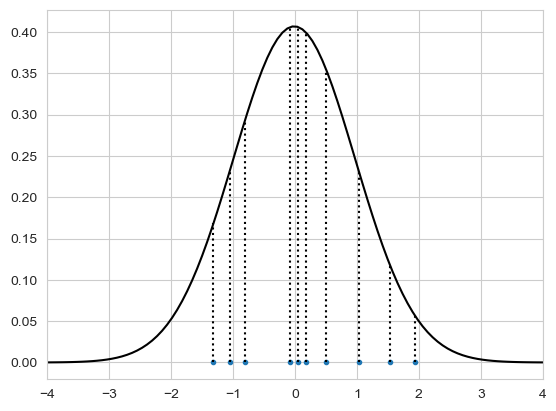

In [190]:
N = 10


X = np.linspace(-4, 4, 100)
Y = norm.pdf(X, mu_est, sigma_est)
plt.plot(X, Y, 'k') # Plot the PDF curve
x = np.random.normal(mu_est, sigma_est, size = (N,)) # Generate random data points from the normal distribution

plt.plot(x, np.zeros(x.shape), '.')
plt.xlim(np.amin(X), np.amax(X))

for i in range(x.size): # Plot dashed lines from each data point to the PDF curve
    plt.plot((x[i], x[i]), (0, norm.pdf(x[i], mu_est, sigma_est)), 'k:'  )

## Maximum A Posteriori

In [192]:
# Define the true parameter (mean of a normal distribution)
true_mean = 5

# Generate random data from the normal distribution
data = np.random.normal(true_mean, 1, size=100)


In [193]:

# Define the prior distribution (another normal distribution) as prior knowledge
prior_mean = 4
prior_std = 2

def pdf_normal(x, mean, std):
    # Calculate the probability density function of a normal distribution
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-(x - mean)**2 / (2 * std**2))


In [194]:

def posterior(x):
    # Likelihood (product of individual data point probabilities)
    likelihood = 1
    for datum in data:
        likelihood *= pdf_normal(datum, x, 1)

    # Prior probability
    prior = pdf_normal(x, prior_mean, prior_std)

    # Posterior probability (product of likelihood and prior)
    return likelihood * prior


In [195]:

# Discretize the parameter space
x_grid = np.linspace(0, 10, 100)  # Adjust range for better fit


In [196]:

# Calculate posterior for each grid point
posterior_values = np.zeros_like(x_grid)
for i, x in enumerate(x_grid):
    posterior_values[i] = posterior(x)


In [197]:
# Normalize the posterior to get a probability distribution
posterior_normalized = posterior_values / np.sum(posterior_values)


In [198]:

# Find the MAP estimate (index of maximum value)
map_estimate = x_grid[np.argmax(posterior_normalized)]


In [199]:
print("True mean:", true_mean)
print("MAP estimate:", map_estimate)

True mean: 5
MAP estimate: 4.848484848484849


In [200]:

# Generate synthetic data
np.random.seed(42)
true_mu = 5
true_sigma = 2
data = np.random.normal(true_mu, true_sigma, size=100)


In [201]:
# Define prior hyperparameters
prior_mu_mean = 0
prior_mu_precision = 1  # Variance = 1 / precision
prior_sigma_alpha = 2
prior_sigma_beta = 2  # Beta = alpha / beta


In [202]:
# Update prior hyperparameters with data
posterior_mu_precision = prior_mu_precision + len(data) / true_sigma**2
posterior_mu_mean = (prior_mu_precision * prior_mu_mean + np.sum(data)) / posterior_mu_precision
posterior_sigma_alpha = prior_sigma_alpha + len(data) / 2
posterior_sigma_beta = prior_sigma_beta + np.sum((data - np.mean(data))**2) / 2


In [203]:
# Calculate posterior parameters
posterior_mu_variance = 1 / posterior_mu_precision
posterior_sigma_variance = posterior_sigma_alpha / posterior_sigma_beta


In [204]:
# Print the updated belief about the mean height
print(f"Updated belief about the mean: {posterior_mu_mean:.2f}")

Updated belief about the mean: 18.43


## Bayesian Inference

In [206]:
sns.set_style('whitegrid')

In [207]:
def gen_data(n=100, eps=0.1):
    X = np.random.uniform([-1,1],[1,1],(n,2))
    X = np.sort(X, axis=0)
    m = np.random.normal(loc=1, scale=1)
    c = np.random.uniform(-1,1)
    w = np.reshape([m,c], (2,1))
    Y_true = np.matmul(X,w)
    eps = np.random.normal(scale=eps, size=(n,1))
    Y = Y_true + eps
    return X,Y,Y_true


In [217]:
def visualize(X, Y, Y_true, mu, sigma, title=None):
    sns.scatterplot(x=X[:,0], y=Y.flatten(), label='Noisy measurement')  # Corrected line
    sns.lineplot(x=X[:,0], y=Y_true.flatten(), label='True function')
    plt.xlabel('X')
    plt.ylabel('Y')
    if not title is None:
        plt.title(title)
    
    # estimation
    Y_pred = np.matmul(X,mu)
    sns.lineplot(x=X[:,0].flatten(), y=Y_pred.flatten(), color='lightgreen', label='Predicted Mean')
    Y0 = np.matmul(X,mu-np.sqrt(np.array([[sigma[0,0]],[0]])))
    Y1 = np.matmul(X,mu+np.sqrt(np.array([[sigma[0,0]],[0]])))
    plt.fill_between(X[:,0].flatten(),Y0[:,0],Y1[:,0], color='lightgreen', alpha=0.3, label='Predicted std')
    Y0 = np.matmul(X,mu-np.sqrt(np.array([[0],[sigma[1,1]]])))
    Y1 = np.matmul(X,mu+np.sqrt(np.array([[0],[sigma[1,1]]])))
    plt.fill_between(X[:,0].flatten(),Y0[:,0],Y1[:,0], color='lightgreen', alpha=0.3)
    plt.legend()



[[0]
 [0]] [[25.  0.]
 [ 0. 25.]]


C:\Users\yashn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yashn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yashn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yashn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

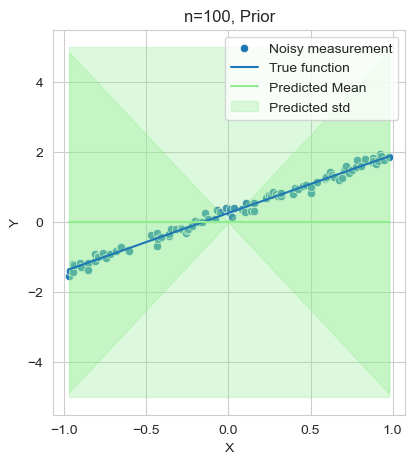

In [219]:
for n in [3,20,100]:
    plt.figure(figsize=(10,5))
    X,Y,Y_true = gen_data(n=n, eps=0.1)
    
# prior
mu = np.array([[0],[0]])
b = 5
sigma = np.eye(2)*b**2
plt.subplot(1,2,1)
visualize(X,Y,Y_true,mu,sigma,title='n={}, Prior'.format(n))
print(mu,sigma)
 

In [220]:
# likelihood
a = 1


C:\Users\yashn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yashn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yashn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\yashn\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

[[1.66090871]
 [0.27893838]] [[ 0.02852583 -0.00133156]
 [-0.00133156  0.01005816]]


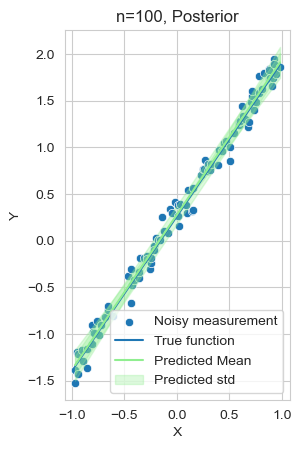

In [223]:
 # posterior
ATA = np.matmul(X.T, X)
Lam = ATA/a**2 + np.eye(2)/b**2
sigma_post = np.linalg.inv(Lam)
mu_post = np.matmul(sigma_post, (np.matmul(X.T, Y)/a**2 + mu/b*82))
plt.subplot(1,2,2)
visualize(X,Y,Y_true,mu_post,sigma_post,title='n={}, Posterior'.format(n))
print(mu_post, sigma_post)


## Variational_Autoencoders_Implementation

In [226]:

# disable_eager_execution()

In [227]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [228]:
# Data Preparation
#For this implementation, we’ll be using the Fashion-MNIST dataset - a collection of grayscale images of clothing items, each of size 28x28 pixels. (show img from internet)
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()


In [229]:
#These images are originally 28 x 28 in grayscale with pixel values ranging from 0 to 255. To make them suitable for our network, we'll preprocess them by scaling the pixel values to be between 0 and 1. Additionally, we'll pad the images to a size of 32 x 32 to simplify how we work with the data as it goes through the network.

In [230]:
## Data Preprocessing

In [231]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [232]:
# display(x_train)

In [233]:
# Designing and Building Variational Autoencoder

In [234]:
#First, we need to create a new Sampling layer for sampling from the distribution defined by z_mean and z_log_var.

In [235]:
#Sampling Layer

class Sampling(layers.Layer):
    #We create a new layer by subclassing the keras base Layer
    def call(self, inputs):
        #
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [236]:
# Encoder

image_size = 32
embed_dim = 2
encoder_input = layers.Input(
    shape=(image_size, image_size, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)

#Instead of connecting the Flatten layer directly to the 2D latent space,
#we will connect it to layers z_mean and z_log_var.
z_mean = layers.Dense(embed_dim, name="z_mean")(x)
z_log_var = layers.Dense(embed_dim, name="z_log_var")(x)

#The Sampling layer samples a point z in the latent space from the
#normal distribution defined by the parameters z_mean and z_log_var.
z = Sampling()([z_mean, z_log_var])

#The Keras Model that defines the encoder—a model that takes an input
#image and outputs z_mean, z_log_var and a sampled point z from the
#normal distribution defined by these parameters.
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 2048)      │          0 │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [237]:
# Decoder
decoder_input = layers.Input(shape=(embed_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [238]:
# Lets Train our Variational Autoencoder

In [239]:
#To create the VAE model, we extend the Keras Model class, enabling us to incorporate the KL
 #divergence calculation
#into a custom train_step method.

In [240]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            #TensorFlow's Gradient Tape helps calculate gradients during a forward pass.
            #To use it, we need wrap the code that performs the operations you want to differentiate within a tf.GradientTape() context.
            #After recording the operations, we can compute the gradient of the loss function concerning certain variables using tape.gradient().
            #These gradients are then used to update the variables with the optimizer.

            z_mean, z_log_var, reconstruction = self(data)
            beta = 500
            reconstruction_loss = tf.reduce_mean(
                beta
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        beta = 500
        reconstruction_loss = tf.reduce_mean(
            beta
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [241]:
vae = VAE(encoder, decoder)

In [252]:
# Starting Training

In [259]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [261]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/modal.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [264]:
#only recontruct images, not classification 
vae.fit(
    x_train,
    epochs=5,
    batch_size=50,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 48s 36ms/step - kl_loss: 4.0868 - reconstruction_loss: 173.6852 - total_loss: 177.7720 - val_kl_loss: 4.8768 - val_loss: 139.4883 - val_reconstruction_loss: 134.6115
Epoch 2/5
   3/1200 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - kl_loss: 4.7277 - reconstruction_loss: 139.1008 - total_loss: 143.8285 

C:\Users\yashn\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1200/1200 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - kl_loss: 4.9649 - reconstruction_loss: 130.7117 - total_loss: 135.6766 - val_kl_loss: 5.1788 - val_loss: 135.3147 - val_reconstruction_loss: 130.1359
Epoch 3/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 49s 41ms/step - kl_loss: 5.1050 - reconstruction_loss: 128.7384 - total_loss: 133.8434 - val_kl_loss: 5.6010 - val_loss: 134.4504 - val_reconstruction_loss: 128.8494
Epoch 4/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 51s 42ms/step - kl_loss: 5.1653 - reconstruction_loss: 127.7418 - total_loss: 132.9071 - val_kl_loss: 5.5177 - val_loss: 132.9489 - val_reconstruction_loss: 127.4312
Epoch 5/5
1200/1200 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - kl_loss: 5.1920 - reconstruction_loss: 127.2425 - total_loss: 132.4345 - val_kl_loss: 5.3359 - val_loss: 132.7515 - val_reconstruction_loss: 127.4156


In [265]:
## Saving Trained Checkpoints

In [266]:
import os

# Create the 'Assignment' directory if it does not exist
if not os.path.exists('Model'):
    os.makedirs('Model')
# Save the final models with the '.keras' extension
vae.save("Model/vae.keras")
encoder.save("Model/encoder.keras")
decoder.save("Model/decoder.keras")


In [267]:
# reconstruct using our trained variational autoencoder

In [268]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

In [269]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real clothing items")
# display(example_images)
print("Reconstructions")
# display(reconstructions)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Example real clothing items
Reconstructions


In [270]:
# Lets visualize Latent Space

In [271]:
z_mean, z_var, z = encoder.predict(example_images)
p = norm.cdf(z)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


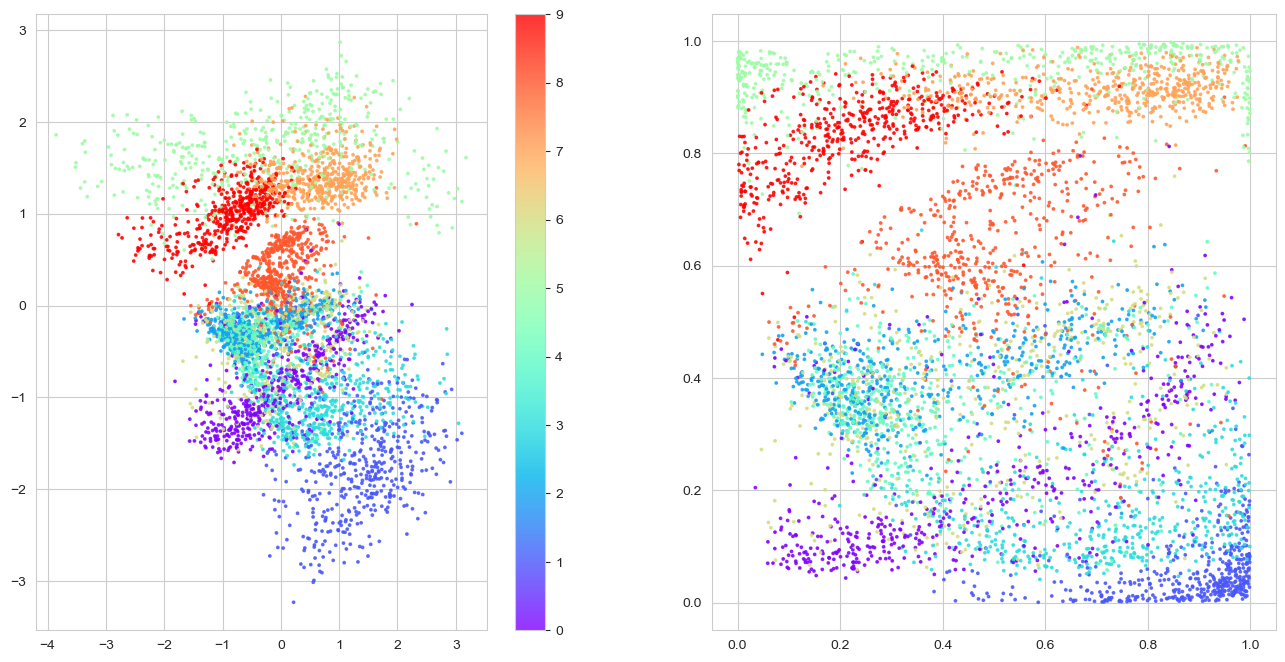

In [272]:



figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(
    z[:, 0], z[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(
    p[:, 0], p[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3
)
plt.show()

Firstly, the KL divergence loss term keeps z_mean and z_log_var values close to a standard normal distribution. Secondly, the stochastic encoder leads to a more continuous latent space, reducing the occurrence of poorly formed images.


Finally, when we color-code points in the latent space by clothing type, we observe that there is no bias favoring any specific type. The right-hand plot displays the space converted into p-values, revealing nearly equal representation for each color. It's crucial to emphasize that the model learned clothing distinctions independently, without using labels during training, to minimize reconstruction loss.